##De-identification Dicom in Spark OCR

####0 Import libs

In [0]:
from johnsnowlabs import nlp,medical,visual

21:41:51, INFO Received command c on object id p1


###1 Define Spark NLP de-identification pipeline

In [0]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = nlp.DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = nlp.SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = nlp.Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = medical.NerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = medical.NerConverterInternal() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = nlp.Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

21:43:20, INFO Received command c on object id p1


###2 Define Spark OCR pipeline

In [0]:
# Read dicom as image
dicom_to_image = visual.DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

adaptive_thresholding = visual.ImageAdaptiveThresholding() \
    .setInputCol("image_raw") \
    .setOutputCol("corrected_image") \
    .setBlockSize(47) \
    .setOffset(4) \
    .setKeepInput(True)

# Extract text from image
ocr = visual.ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("text")

# Found coordinates of sensitive data
position_finder = visual.PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setPadding(1)

# Found sensitive data using DeIdentificationModel
deidentification_rules = medical.DeIdentificationModel.pretrained("deidentify_rb_no_regex", "en", "clinical/models") \
    .setInputCols(["metadata_sentence", "metadata_token", "metadata_ner_chunk"]) \
    .setOutputCol("deidentified_metadata_raw")

finisher = nlp.Finisher() \
    .setInputCols(["deidentified_metadata_raw"]) \
    .setOutputCols("deidentified_metadata") \
    .setOutputAsArray(False) \
    .setValueSplitSymbol("") \
    .setAnnotationSplitSymbol("")

# Draw filled rectangle for hide sensitive data
drawRegions = visual.ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(visual.Color.black)

# Store image back to Dicom document
imageToDicom = visual.ImageToDicom() \
    .setInputCol("image_with_regions") \
    .setOutputCol("dicom") 
    
# OCR pipeline
deid_pipeline = nlp.PipelineModel(stages=[
    dicom_to_image,
    adaptive_thresholding,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions,
    #imageToDicom  # Commented for able to demonstrate intermidiate results before aggregation
])

21:50:09, INFO Received command c on object id p1


deidentify_rb_no_regex download started this may take some time.
[ | ]

21:50:09, INFO Received command c on object id p0
21:50:10, INFO Received command c on object id p0
21:50:11, INFO Received command c on object id p0


[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ]

21:50:12, INFO Received command c on object id p0
21:50:13, INFO Received command c on object id p0
21:50:14, INFO Received command c on object id p0


[OK!]
ner_deid_large download started this may take some time.
[ | ]

21:50:15, INFO Received command c on object id p0
21:50:16, INFO Received command c on object id p0


[OK!]


21:50:17, INFO Received command c on object id p0
21:50:18, INFO Received command c on object id p0
21:50:19, INFO Received command c on object id p0
21:50:20, INFO Received command c on object id p0
21:50:21, INFO Received command c on object id p0


###3 Prepare documents

In [0]:
%sh
OCR_DIR=/dbfs/tmp/deid_dicom_ocr
if [ ! -d "$OCR_DIR" ]; then
    mkdir $OCR_DIR
    cd $OCR_DIR
    wget https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-2.dcm  
    wget https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm 
fi

In [0]:
display(dbutils.fs.ls("dbfs:/tmp/deid_dicom_ocr/"))

21:50:51, INFO Received command c on object id p1


path,name,size,modificationTime
dbfs:/tmp/deid_dicom_ocr/deidentify-brains-front-medical-3.dcm,deidentify-brains-front-medical-3.dcm,3836142,1653324161000
dbfs:/tmp/deid_dicom_ocr/deidentify-medical-2.dcm,deidentify-medical-2.dcm,900924,1653324161000


In [0]:
file_path='dbfs:/tmp/deid_dicom_ocr/*.dcm'
dicom_df = spark.read.format("binaryFile").load(file_path)
display(dicom_df)

21:53:12, INFO Received command c on object id p1
21:53:12, INFO Received command c on object id p0
21:53:13, INFO Received command c on object id p0


path,modificationTime,length,content
dbfs:/tmp/deid_dicom_ocr/deidentify-brains-front-medical-3.dcm,2022-05-23T16:42:41Z,3836142,AgABAE9CAAACAAAAAAECAAIAVUksADIuMjUuMzI0MjI3ODYwOTczMDMyOTU1MDAzMjcwMTQyNzY5NTcxODIzNzUxAgADAFVJLAAyLjI1LjE0MDgyNzQzMzUwNDgzODcyNzM4MzEyMDk1MzgxNTY4NDA0NTcwMwIAEABVSRQAMS4= (truncated)
dbfs:/tmp/deid_dicom_ocr/deidentify-medical-2.dcm,2022-05-23T16:42:41Z,900924,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA= (truncated)


In [0]:
visual.display_images(visual.DicomToImage().transform(dicom_df))

21:53:18, INFO Received command c on object id p0
21:53:19, INFO Received command c on object id p0
21:53:20, INFO Received command c on object id p0


Origin: dbfs:/tmp/deid_dicom_ocr/deidentify-brains-front-medical-3.dcm 
 Resolution: 0 dpi 
 Width: 1520 px 
 Height: 841 px 
 Mode: Greyscale 
 Number of channels: 1 
 
 
 
 
 
 
 
 Origin: dbfs:/tmp/deid_dicom_ocr/deidentify-brains-front-medical-3.dcm 
 Resolution: 0 dpi 
 Width: 1520 px 
 Height: 841 px 
 Mode: Greyscale 
 Number of channels: 1 
 
 
 
 
 
 
 
 Origin: dbfs:/tmp/deid_dicom_ocr/deidentify-brains-front-medical-3.dcm 
 Resolution: 0 dpi 
 Width: 1520 px 
 Height: 841 px 
 Mode: Greyscale 
 Number of channels: 1 
 
 
 
 
 
 
 
 Origin: dbfs:/tmp/deid_dicom_ocr/deidentify-medical-2.dcm 
 Resolution: 0 dpi 
 Width: 914 px 
 Height: 985 px 
 Mode: Greyscale 
 Number of channels: 1

###4 Run pipeline

In [0]:
deid_results = deid_pipeline.transform(dicom_df).cache()

#### Display detected text

In [0]:
display(deid_results.select("text"))

21:55:27, INFO Received command c on object id p0
21:55:28, INFO Received command c on object id p0
21:55:29, INFO Received command c on object id p0
21:55:30, INFO Received command c on object id p0
21:55:31, INFO Received command c on object id p0
21:55:32, INFO Received command c on object id p0
21:55:33, INFO Received command c on object id p0
21:55:34, INFO Received command c on object id p0
21:55:35, INFO Received command c on object id p0
21:55:36, INFO Received command c on object id p0
21:55:37, INFO Received command c on object id p0
21:55:38, INFO Received command c on object id p0
21:55:39, INFO Received command c on object id p0
21:55:40, INFO Received command c on object id p0
21:55:41, INFO Received command c on object id p0
21:55:42, INFO Received command c on object id p0
21:55:43, INFO Received command c on object id p0
21:55:44, INFO Received command c on object id p0
21:55:45, INFO Received command c on object id p0
21:55:46, INFO Received command c on object id p0


text
Patient Name: Peter Maxime Patient ID: MF-0000013 Patient Birth Date: 197500704
Patient Name: Peter Maxime
Patient Name: Peter Maxime
"Name: Good, Guy PID: 125-98-445 Sex: PatientSex 08/02/1929 LEAD ~&, fae re we, : ‘ EER es Fit, Mag: 1.79X, mT Tm LT LT LT Unit: 0.1¢"


#### Display Ner chunks

In [0]:
display(deid_results.select("ner_chunk"))

21:55:53, INFO Received command c on object id p1
21:55:53, INFO Received command c on object id p0


ner_chunk
"List(List(chunk, 28, 39, Peter Maxime, Map(chunk -> 0, confidence -> 0.96585, ner_source -> ner_chunk, entity -> NAME, sentence -> 0), List()), List(chunk, 53, 62, MF-0000013, Map(chunk -> 1, confidence -> 0.8424, ner_source -> ner_chunk, entity -> DATE, sentence -> 0), List()))"
"List(List(chunk, 14, 25, Peter Maxime, Map(chunk -> 0, confidence -> 0.90585, ner_source -> ner_chunk, entity -> NAME, sentence -> 0), List()))"
"List(List(chunk, 14, 25, Peter Maxime, Map(chunk -> 0, confidence -> 0.90585, ner_source -> ner_chunk, entity -> NAME, sentence -> 0), List()))"
"List(List(chunk, 6, 14, Good, Guy, Map(chunk -> 0, confidence -> 0.72480005, ner_source -> ner_chunk, entity -> NAME, sentence -> 0), List()), List(chunk, 48, 57, 08/02/1929, Map(chunk -> 1, confidence -> 1.0, ner_source -> ner_chunk, entity -> DATE, sentence -> 0), List()))"


####Display coordinates of text which need to hide

In [0]:
display(deid_results.select('coordinates').limit(2))

21:55:59, INFO Received command c on object id p1
21:55:59, INFO Received command c on object id p0


coordinates
"List(List(0, 0, 215.0, 452.35, 552.0, 80.3, 0.0, 0, 0.0))"
"List(List(0, 1, 445.0, 39.0, 528.0, 16.0, 0.0, 0, 0.0))"


###4 Display original and de-identified results

In [0]:
import matplotlib.pyplot as plt

21:56:49, INFO Received command c on object id p1


21:56:58, INFO Received command c on object id p1
21:56:59, INFO Received command c on object id p0


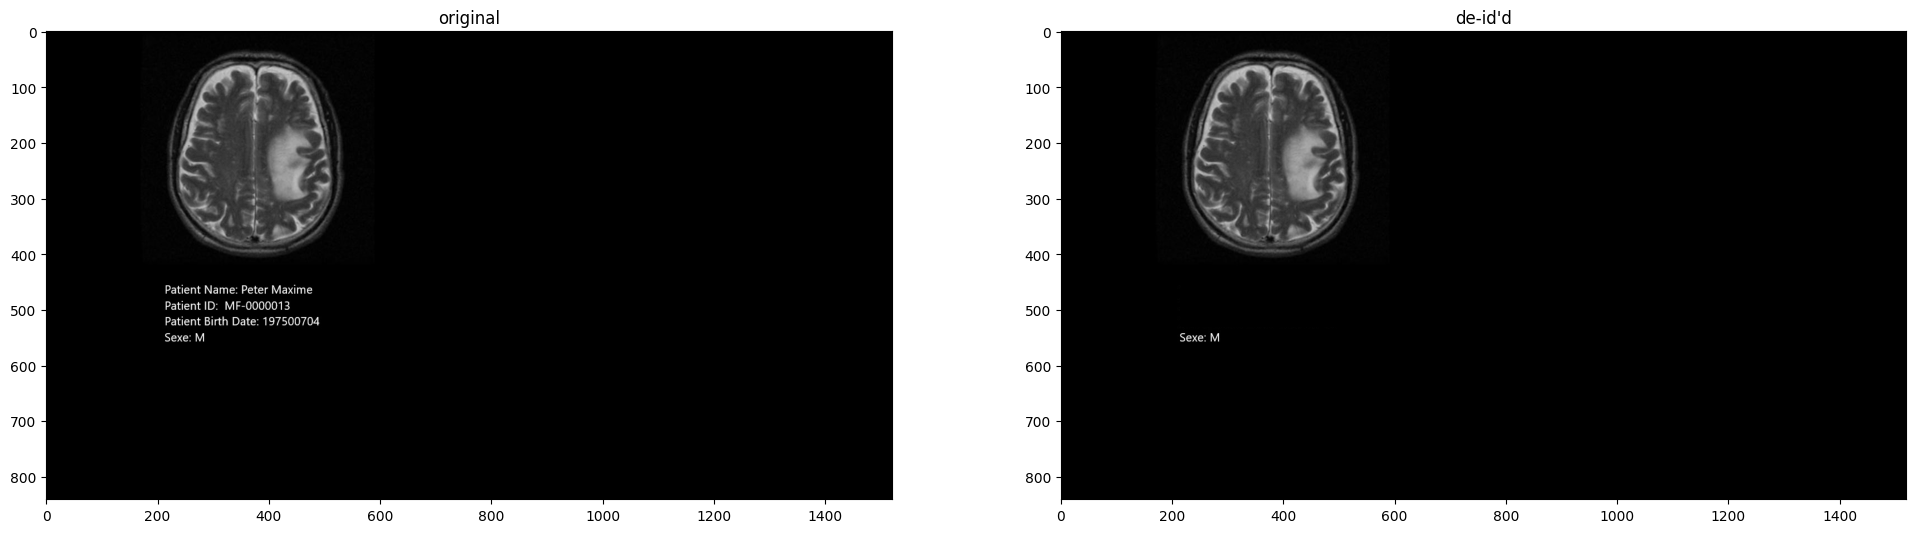

21:56:59, INFO Received command c on object id p0


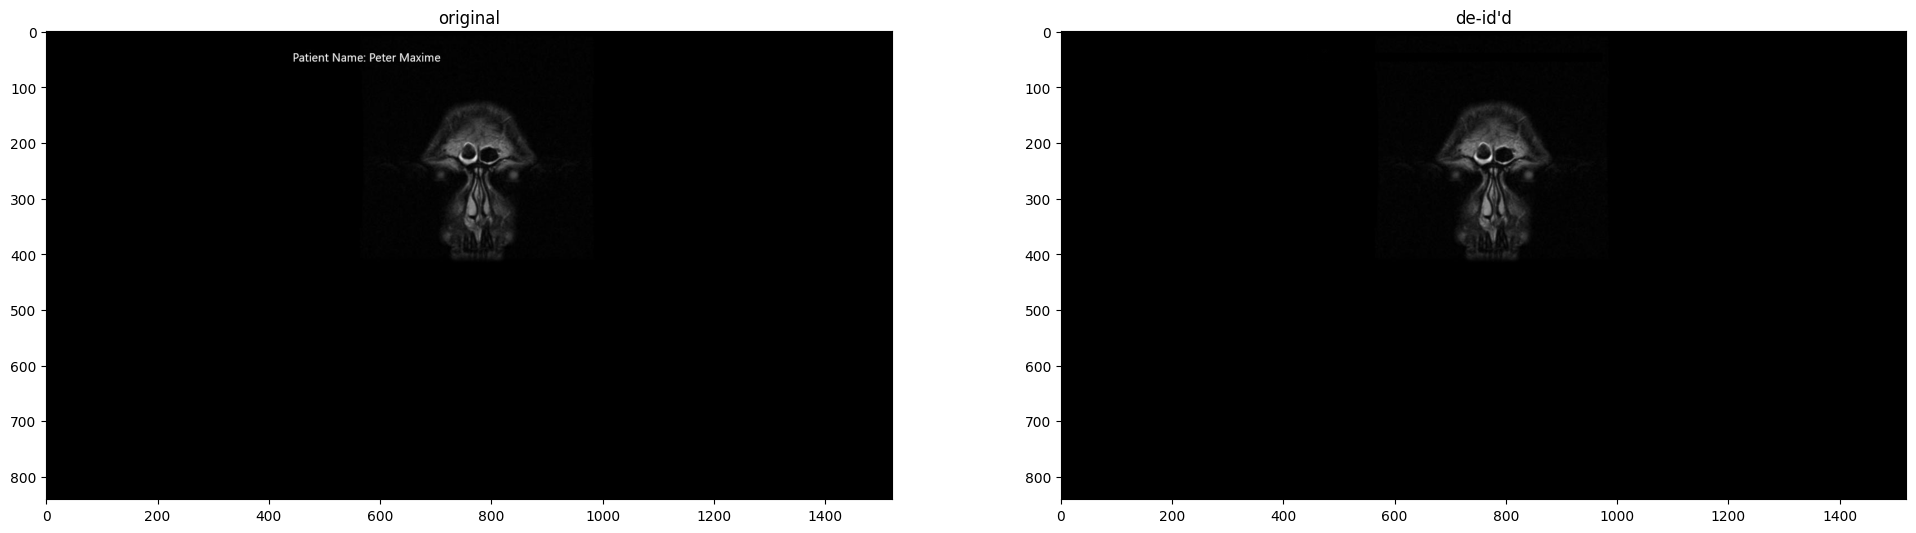

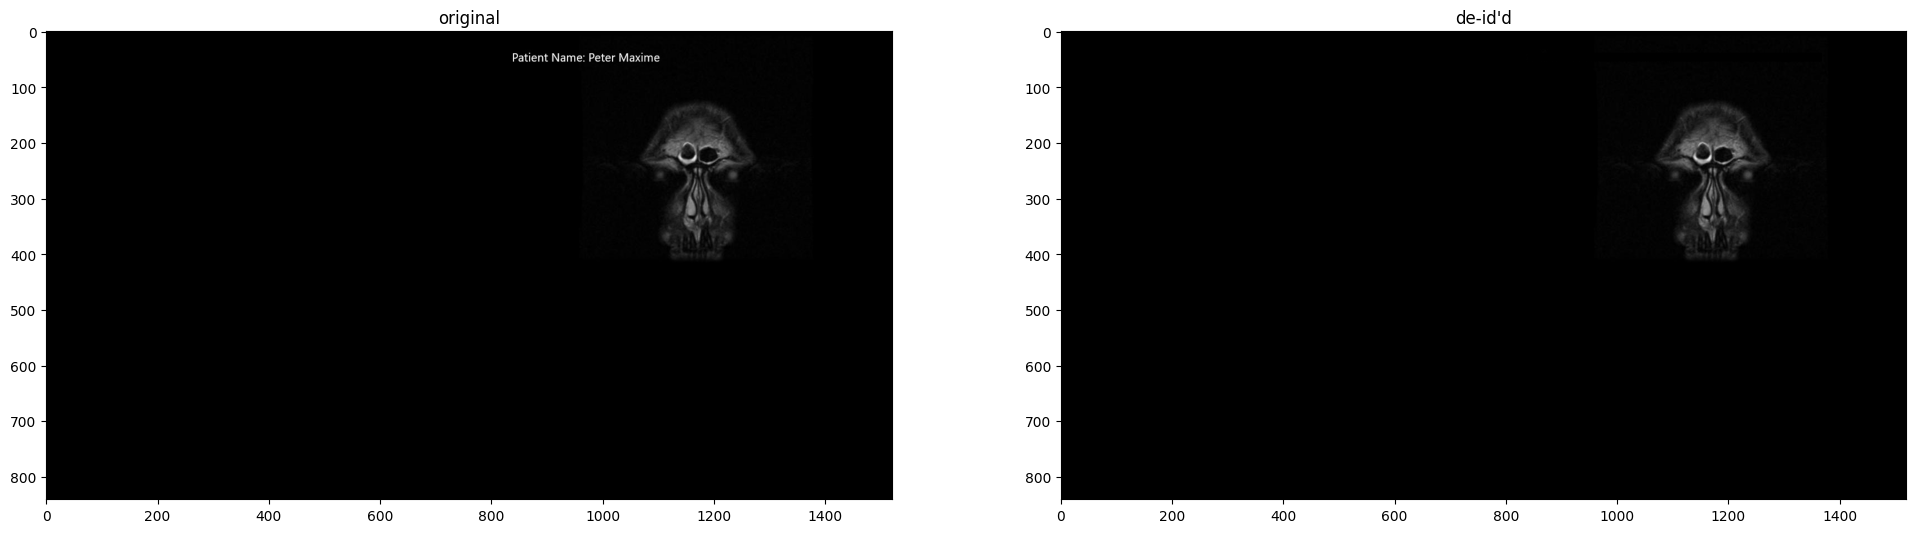

21:57:00, INFO Received command c on object id p0


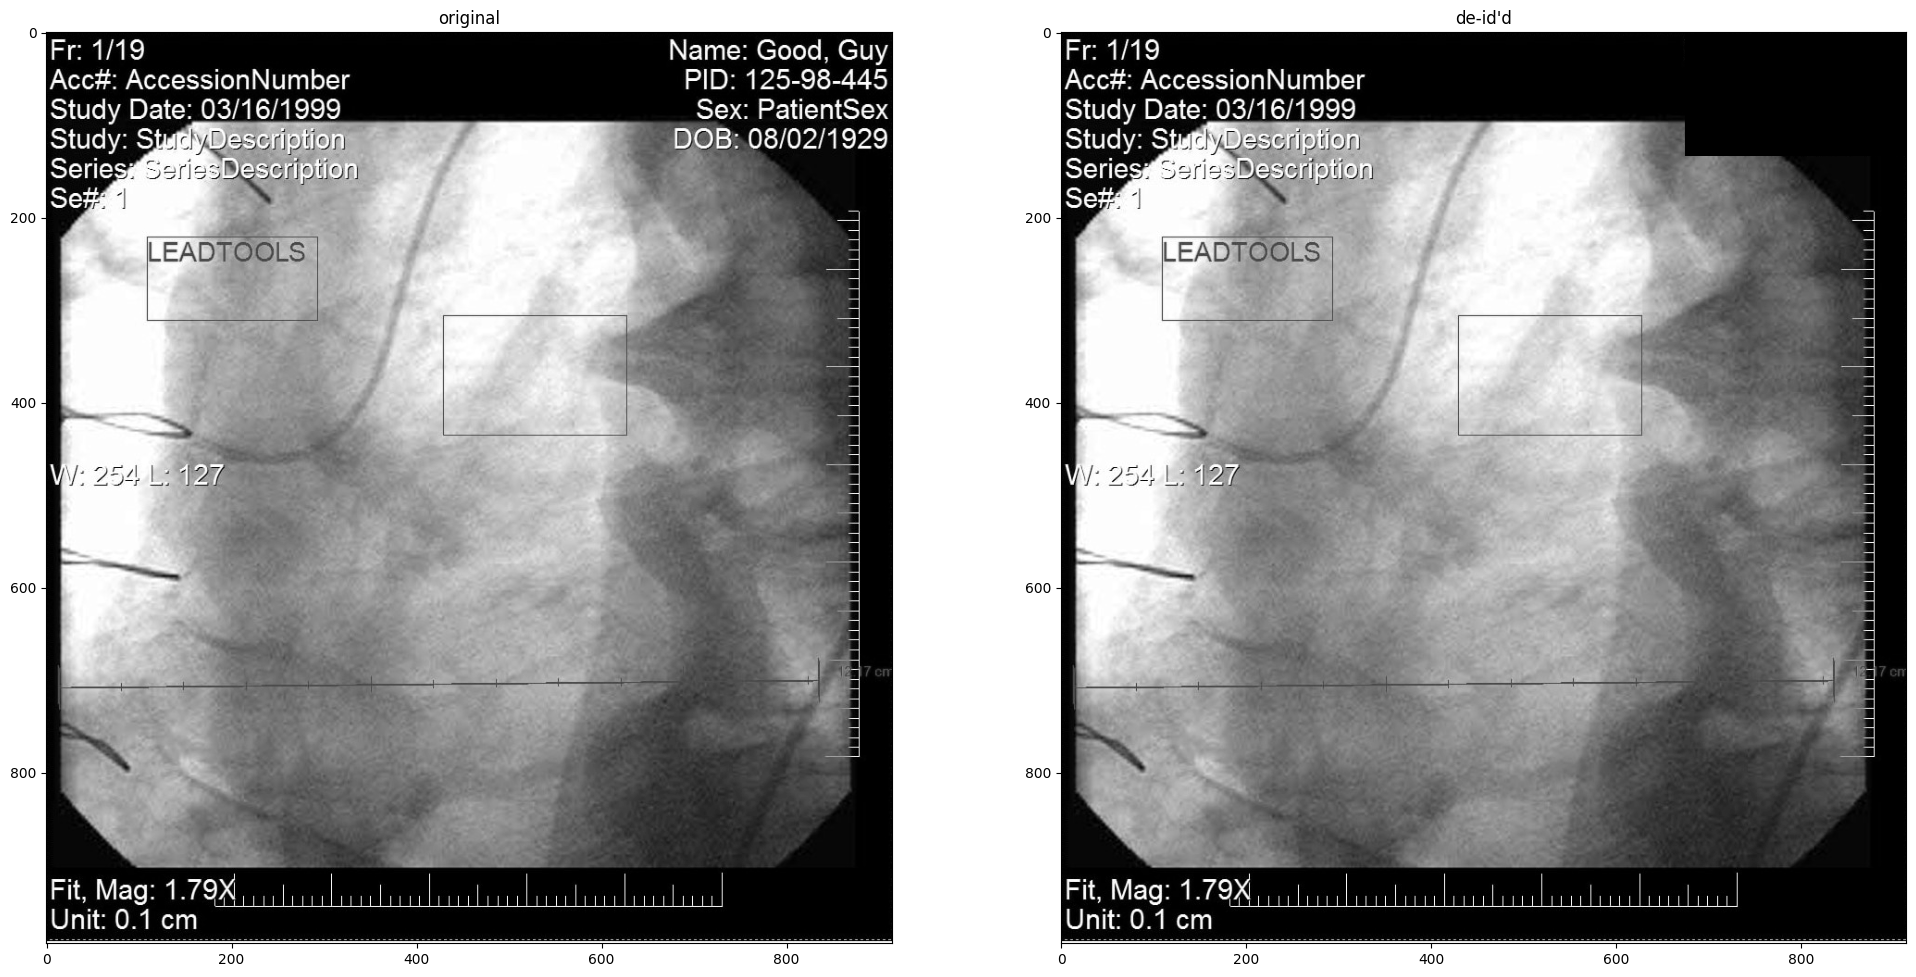

In [0]:
for r in deid_results.select("image_raw", "image_with_regions").collect():
  img_orig = r.image_raw
  img_deid = r.image_with_regions

  img_pil_orig = visual.to_pil_image(img_orig, img_orig.mode)
  img_pil_deid = visual.to_pil_image(img_deid, img_deid.mode)

  plt.figure(figsize=(24,16))
  plt.subplot(1, 2, 1)
  plt.imshow(img_pil_orig, cmap='gray')
  plt.title('original')
  plt.subplot(1, 2, 2)
  plt.imshow(img_pil_deid, cmap='gray')
  plt.title("de-id'd")
  plt.show()